In [1]:
import matplotlib.pyplot as plt
from pathlib import Path
import torch
import torch.nn.functional as F

%matplotlib inline

In [2]:
# Constants
BLOCK_SIZE = 3  # number of characters to use as context
ALPHABET_SIZE = 27  # size of alphabet
EMBEDDING_SIZE = 2  # dimension for each embedding space (for each character)
LAYER_SIZE = 100  # number of neurons in fully-connected layer
LEARNING_RATE = 0.1  # size of step to take in gradient
MINIBATCH_SIZE = 32  # number of minibatches?

In [3]:
names_fpath = Path.cwd() / "names.txt"
with open(names_fpath, "r") as f:
    names = f.read()
names = names.split("\n")

# Build vocabulary of characters, map idx -> char and vice-versa
chars = sorted(list(set(''.join(names))))
chars_to_i = {c: i+1 for i, c in enumerate(chars)}
chars_to_i["."] = 0
i_to_chars = {i: c for c, i in chars_to_i.items()}

In [4]:
# Build dataset
X, y = [], []
for n in names:
    context = [0] * BLOCK_SIZE
    for ch in n + ".":
        idx = chars_to_i[ch]
        X.append(context)
        y.append(idx)
        context = context[1:] + [idx]

X = torch.tensor(X)
y = torch.tensor(y)
X.shape, X.dtype, y.shape, y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [5]:
# Look-up table
# Embeds each character in two-dimensional space
# Alphabet is of size 27
C = torch.randn((ALPHABET_SIZE, EMBEDDING_SIZE))

# C[X] = X.shape[0] x 3 x 2 tensor
# Every row of C[X] = 3x2 tensor
# e.g., C[X][0] = [
#    [A, B],
#    [C, D],
#    [E, F],
# ] 
# where [A, B] is embedding of X[0][0]
embeddings = C[X]
embeddings.shape
# X.shape[0] x 3 x 2

# Concatenate character embeddings together
# Take advantage of PyTorch internals using `view`
# In reality, we wouldn't want to do this in prod, since this is not memory-efficient
embeddings = embeddings.view(X.shape[0], 6)
embeddings.shape
# X.shape[0] x 6


torch.Size([228146, 6])

In [6]:
# Fully-connected layer
# Each neuron should have 6 inputs
# Why 6? 
#   input = context of characters
#   context = BLOCK_SIZE characters
#   each character = EMBEDDING_SIZE
#   total input = BLOCK_SIZE * EMBEDDING_SIZE
#   at time of writing, BLOCK_SIZE = 3 and EMBEDDING_SIZE = 2
W1 = torch.randn((BLOCK_SIZE * EMBEDDING_SIZE, LAYER_SIZE))
b1 = torch.randn(LAYER_SIZE)
h = torch.tanh(embeddings @ W1 + b1)  # be careful about broadcasting here!

# Output layer
W2 = torch.randn((LAYER_SIZE, ALPHABET_SIZE))
b2 = torch.randn(ALPHABET_SIZE)

# Logits 
logits = h @ W2 + b2
logits.shape

# Softmax
# Cross-entropy loss after applying softmax (MANUAL -  just for educational)
# counts = logits.exp()
# probs = counts / counts.sum(dim=1, keepdim=True)
# loss = -(probs[torch.arange(probs.shape[0]), y].log().mean())

# Cross-entroy loss using PyTorch
loss = F.cross_entropy(logits, y)


In [7]:
params = [C, W1, b1, W2, b2]
for p in params:
    p.requires_grad = True

N = 1000

In [8]:
lr_exponents = torch.linspace(-3, 0, N)
lr_candidates = 10**lr_exponents


In [9]:
lri = []
losses = []

# Putting it all together...
for i in range(N):
    # Minibatch construct
    idx = torch.randint(0, X.shape[0], (MINIBATCH_SIZE,))

    # Forward pass
    h = torch.tanh(C[X[idx]].view(-1, BLOCK_SIZE * EMBEDDING_SIZE) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y[idx])

    # Backward pass
    for p in params:
        p.grad = None
    loss.backward()
    
    # Update
    lr = lr_candidates[i]
    for p in params:
        p.data += -lr * p.grad
    
    # Track stats
    lri.append(lr_exponents[i])
    losses.append(loss.item())
    

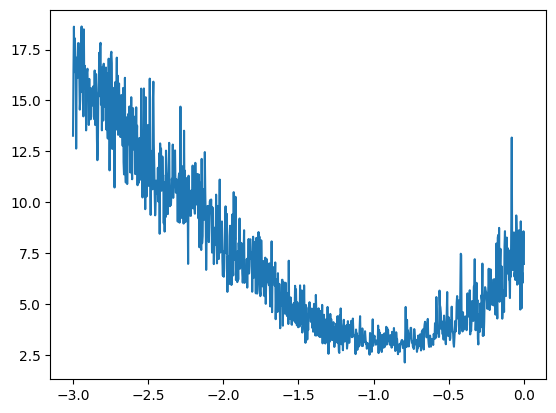

In [10]:
plt.plot(lri, losses)

In [11]:
# Full loss
emb = C[X]
h = torch.tanh((emb.view(-1, BLOCK_SIZE * EMBEDDING_SIZE)) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, y)
loss

tensor(8.7004, grad_fn=<NllLossBackward0>)